## 라이브러리 및 딕셔너리를 선언

In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import timm
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [51]:
sashimi_category = {'Olive_flounder_sashimi' : 0,
                    'Korea_rockfish_sashimi' : 1,
                    'Red_seabream_sashimi' : 2,
                    'Brown_croaker_sashimi' : 3,
                    'Red_drum_sashimi' : 4,
                    'Tilapia_sashimi' : 5,
                    'Salmon_sashimi' : 6,
                    'Tuna_sashimi' : 7,
                    'Japanese_amberjack_sashimi' : 8
                   }

### cuda 연결

In [52]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Currently using {device}...')

Currently using cuda...


### model pth 가져오기

In [53]:
class TempModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = timm.create_model('efficientnet_b4', pretrained = True, num_classes = num_classes, drop_rate=0.5, act_layer = nn.ReLU)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

file_path = './sashimi_EfficientNetB4_best_epoch41_0.8336.pth'
model = TempModel(num_classes =9)
model.to(device)
model.load_state_dict(torch.load(file_path))
model.eval()

TempModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affi

### 계산을 위해 Feature map 과 class weight를 가져오자 

##### hook을 이용

In [54]:
# making hook
activation=None
class_weight = None

def hook_4_fm(model,input,output):
    global activation
    activation =output.clone().detach().requires_grad_(True)

def hook_4_clf_w(model,input,output):
    global class_weight
    class_weight = model.weight

model.efficientnet.conv_head.register_forward_hook(hook_4_fm)
model.efficientnet.classifier.register_forward_hook(hook_4_clf_w)

### 데이터 전처리

In [55]:
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2

class transforms_1:
    def __init__(self, resize) -> None:
        self.transforms = A.Compose([
            A.Resize(*resize, cv2.INTER_LINEAR),
            A.Normalize(),
            ToTensorV2(),
        ])
    
    def __call__(self, image):
        return self.transforms(image=image)

transform=A.Compose([
        A.Resize(384, 384),
        A.Normalize(),
        ToTensorV2(),
    ])

trans_resize = A.Compose([
    A.Resize(384,384)
])

In [56]:
current_path = os.getcwd()
dataset_dir = os.path.join(current_path,"test_data")

data_list = os.listdir(dataset_dir)
data_list

['참치.jpg']

In [57]:
image_name = data_list[0]

#추후 비교를 위해 따로 저장
origin_image = np.array(cv2.imread(os.path.join(dataset_dir,image_name)))
origin_image = trans_resize(image=origin_image)['image']

#학습을 위한 데이터
image = transform(image=origin_image)['image']
image = image.unsqueeze(0)
image = image.to(device, dtype=torch.float32)


In [58]:
output = model(image)
preds = torch.argmax(output, dim=-1)
tmp = activation.squeeze(axis = 0)
print(tmp.shape)
print(class_weight.shape)
label_weight = class_weight[preds[0]]
print(label_weight.shape)
label_weight = label_weight.unsqueeze(-1).unsqueeze(-1)
print(label_weight.shape)


torch.Size([1792, 12, 12])
torch.Size([9, 1792])
torch.Size([1792])
torch.Size([1792, 1, 1])


In [59]:
cam = torch.squeeze(tmp)* label_weight
cam = torch.sum(cam,axis = 0)
cam = cam.detach().cpu().numpy()

정답 :  참치.jpg
예측 :  Salmon_sashimi


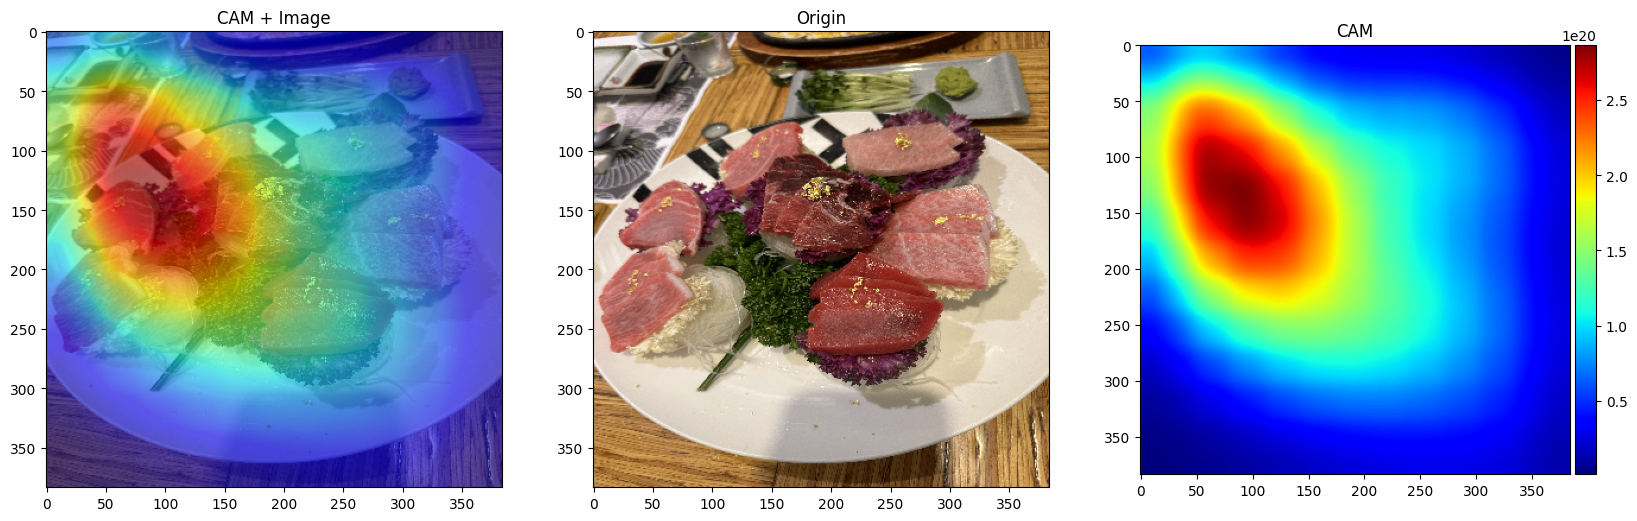

In [60]:
#origin = origin_img.detach().cpu().numpy()
from mpl_toolkits.axes_grid1 import make_axes_locatable

final_cam = cv2.resize(cam, dsize=(384, 384), interpolation= cv2.INTER_CUBIC)

img_rgb = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,40))

plt.subplot(1,3,1)
plt.title("CAM + Image")

#plt.imshow(origin_image)
plt.imshow(img_rgb)
plt.imshow(final_cam,cmap = 'jet' ,alpha=0.6)

plt.subplot(1,3,2)
plt.title("Origin")
#plt.imshow(origin_image)
plt.imshow(img_rgb)


ax = plt.subplot(1,3,3)
plt.title("CAM")
im =plt.imshow(final_cam, cmap = 'jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(im, cax= cax)
print("정답 : ", image_name)
keys = sashimi_category.keys()
key_lst = list(keys)
print("예측 : ",key_lst[preds[0]])

### 연속 실행

In [61]:
current_path = os.getcwd()
dataset_dir = os.path.join(current_path,"test_data")

data_list = os.listdir(dataset_dir)


def CAM (image_name):
    #추후 비교를 위해 따로 저장
    origin_image = np.array(cv2.imread(os.path.join(dataset_dir,image_name)))
    origin_image = trans_resize(image=origin_image)['image']

    #학습을 위한 데이터
    image = transform(image=origin_image)['image']
    image = image.unsqueeze(0)
    image = image.to(device, dtype=torch.float32)


    #inference 진행
    output = model(image)
    preds = torch.argmax(output, dim=-1)

    #feature map 뽑아내기
    tmp = activation.squeeze(axis = 0)

    #class weight 뽑아내기
    label_weight = class_weight[preds[0]]

    #연산을 위한 차원 변환
    label_weight = label_weight.unsqueeze(-1).unsqueeze(-1)

    #cam 만들기
    cam = torch.squeeze(tmp)* label_weight
    cam = torch.sum(cam,axis = 0)
    cam = cam.detach().cpu().numpy()

    # 사진을 겹쳐보기 위한 resize 해주기
    final_cam = cv2.resize(cam, dsize=(384, 384), interpolation= cv2.INTER_CUBIC)


    img_rgb = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

    #시각화
    plt.figure(figsize=(20,40))

    plt.subplot(1,3,1)
    plt.title("CAM + Image")

    plt.imshow(img_rgb)
    plt.imshow(final_cam,cmap = 'jet' ,alpha=0.6)

    plt.subplot(1,3,2)
    plt.title("Origin")
    plt.imshow(img_rgb)

    ax = plt.subplot(1,3,3)
    plt.title("CAM")
    im =plt.imshow(final_cam, cmap = 'jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    plt.colorbar(im, cax= cax)
    print("파일이름 : ", image_name)
    keys = sashimi_category.keys()
    key_lst = list(keys)
    print("예측 : ",str(key_lst[preds[0]]))

## 아래의 코드를 연속 실행해주자

In [62]:
#초기화
index = 0

파일이름 :  참치.jpg
예측 :  Salmon_sashimi


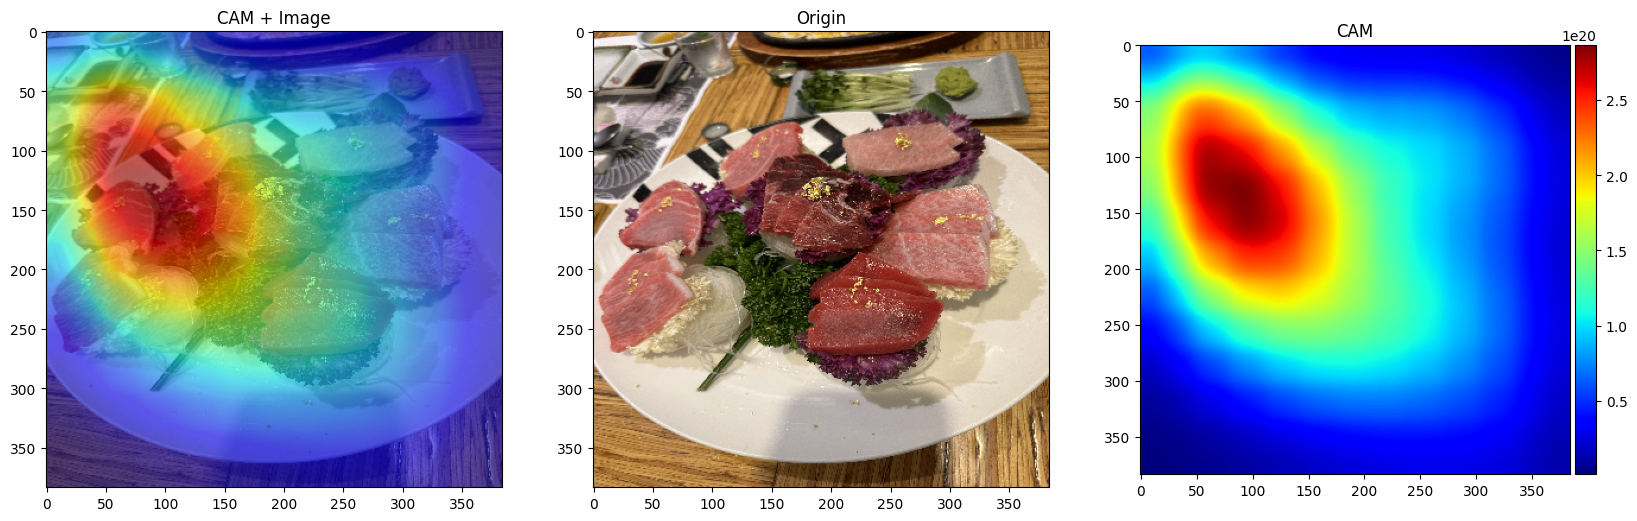

In [63]:
try:
    CAM(data_list[index])
    index +=1
except IndexError:
    print("Finish")